In [1]:
import pandas as pd
import numpy as np
import math

from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LogisticRegression, Lasso, Ridge
from sklearn.tree         import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble     import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor

from sklearn.model_selection import StratifiedKFold, RepeatedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import accuracy_score      as acc
from sklearn.metrics import f1_score            as f1
from sklearn.metrics import make_scorer

In [2]:
df = pd.read_csv("./data/task5/Train.csv")
df

,id,date,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,...,kw5,kw6,kw7,kw8,kw9,kw10,kw11,kw12,kw13,price
0,0,2011-1,616,0.0,4,43,2,0,30.0,1.0,...,0,0,0,0,0,0,0,0,0,1738000
1,1,2011-1,112,0.0,3,33,1,0,15.0,1.0,...,0,0,0,0,0,0,0,0,0,1169000
2,2,2011-1,230,NaN,9,34,1,0,25.0,NaN,...,0,0,0,0,0,0,0,0,0,2821000
3,3,2011-1,302,1.0,4,60,3,0,15.0,0.0,...,0,0,0,0,0,0,0,0,0,5714000
4,4,2011-1,578,0.0,3,49,2,0,30.0,NaN,...,0,0,0,0,0,0,0,0,0,1660000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,99995,2012-3,612,0.0,3,36,1,0,30.0,NaN,...,0,0,0,0,0,0,0,0,0,3898000
99996,99996,2012-3,573,0.0,4,51,2,0,30.0,NaN,...,0,0,0,0,0,0,0,0,0,8698000
99997,99997,2012-3,550,NaN,9,48,2,0,30.0,0.0,...,0,0,0,0,0,0,0,0,0,6498000
99998,99998,2012-3,595,1.0,10,51,2,1,15.0,1.0,...,0,0,0,0,0,0,0,0,0,9436000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E7A3AB78C8>]],
      dtype=object)

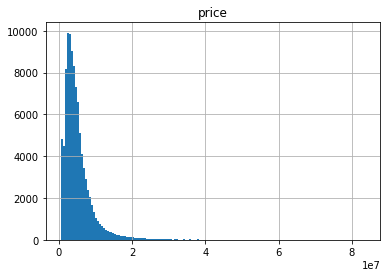

In [3]:
df.hist(column = 'price', bins = 150)

## Преобразование признаков ##
### Заполнение пропусков ###
Пропуски есть в признаках `build_tech`, `metro_dist`, `g_lift`.
- Пропуски в `metro_dist` заполним средним значением по соответсвующей улице
- Пропуски в `build_tech` заполним наиболее часто значениями 0.0, 1.0 и 2.0 случайно
- Пропуски в `build_tech` заполним случайно

In [4]:
for street_id in tqdm_notebook(set(df['street_id'])):
    missed_value = np.mean(df[df['street_id'] == street_id]["metro_dist"])
    for id_ in df[df['street_id'] == street_id]['id']:
        if np.isnan(df['metro_dist'][id_]):
            df['metro_dist'][id_] = missed_value

In [5]:
value_counts = df["build_tech"].value_counts()
total_count = value_counts[0] + value_counts[1] + value_counts[2]
p_0  = value_counts[0] / total_count
p_1  = value_counts[1] / total_count
p_2  = value_counts[2] / total_count
perm = [p_0, p_1, p_2]

for id_ in tqdm_notebook(df['id']):
    if np.isnan(df['build_tech'][id_]):
        df['build_tech'][id_] = np.random.choice([0.0, 1.0, 2.0], p = perm)

In [6]:
for id_ in tqdm_notebook(df['id']):
    if np.isnan(df['g_lift'][id_]):
        df['g_lift'][id_] = np.random.choice([0.0, 1.0])

### Преобразование признаков ###
- `date` разделим на 2 признака `year` и `month`
- `price` прологарифмируем, отбросим наибольшие значения

In [7]:
year  = []
month = []
time  = []
for id_ in tqdm_notebook(df['id']):
    data = df['date'][id_].split('-')
    curr_month = int(data[1])
    curr_year =  int(data[0])
    year.append( curr_year )
    month.append(curr_month)
    curr_time = curr_month
    if curr_year > 2011:
        curr_time += 12
    time.append(curr_time)
df['year']  = year
df['month'] = month
df['time'] = time
df.drop(['date'], axis='columns', inplace=True)

In [8]:
df['price_log'] = np.log(df['price'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E7A43D30C8>]],
      dtype=object)

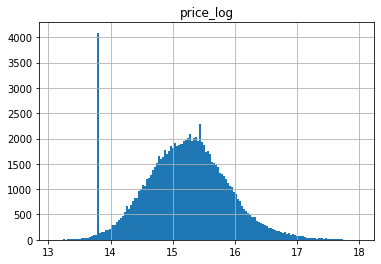

In [9]:
df = df[df['price_log'] < 18]
df.hist(column = 'price_log', bins = 150)

Как видим, на гистограмме получился "выброс", соответсвующий значению **13.815511**. Добавим столбец-индикатор, является ли значение цены выбросом в таблицу

In [10]:
indicator = []
for id_ in tqdm_notebook(df['id']):
    indicator.append(int(df['price_log'][id_] < 13.815 or df['price_log'][id_] > 13.816))
df['class'] = indicator    

In [11]:
df['class'].value_counts()

1    96026
0     3968
Name: class, dtype: int64

In [12]:
df

,id,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,n_photos,...,kw10,kw11,kw12,kw13,price,year,month,time,price_log,class
0,0,616,0.0,4,43,2,0,30.0,1.0,1,...,0,0,0,0,1738000,2011,1,1,14.368246,1
1,1,112,0.0,3,33,1,0,15.0,1.0,2,...,0,0,0,0,1169000,2011,1,1,13.971659,1
2,2,230,1.0,9,34,1,0,25.0,1.0,4,...,0,0,0,0,2821000,2011,1,1,14.852602,1
3,3,302,1.0,4,60,3,0,15.0,0.0,2,...,0,0,0,0,5714000,2011,1,1,15.558430,1
4,4,578,0.0,3,49,2,0,30.0,0.0,2,...,0,0,0,0,1660000,2011,1,1,14.322328,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,99995,612,0.0,3,36,1,0,30.0,1.0,3,...,0,0,0,0,3898000,2012,3,15,15.175974,1
99996,99996,573,0.0,4,51,2,0,30.0,1.0,3,...,0,0,0,0,8698000,2012,3,15,15.978604,1
99997,99997,550,0.0,9,48,2,0,30.0,0.0,0,...,0,0,0,0,6498000,2012,3,15,15.687005,1
99998,99998,595,1.0,10,51,2,1,15.0,1.0,1,...,0,0,0,0,9436000,2012,3,15,16.060043,1


## Моделька ##
Идея - разбить задачу на 2 этапа:
- Решить задачу классификации (определение выброса)
- Для значений, которые не являются выбросами, построить регрессию

### Классификация ###

In [62]:
train_names = ['street_id', 'build_tech', 'floor', 'area', 'rooms', 'balcon',
               'metro_dist', 'g_lift', 'n_photos', 'kw1', 'kw2', 'kw3', 'kw4', 'kw5',
               'kw6', 'kw7', 'kw8', 'kw9', 'kw10', 'kw11', 'kw12', 'kw13', 'time']
X       = df[train_names]
y_class = df['class']

sc = StandardScaler()
X_scaled = sc.fit_transform(X)

In [63]:
LR = LogisticRegression(solver='liblinear', random_state=42)

train_f1 = []
test_f1  = []
kfold = RepeatedKFold(n_splits = 5, n_repeats = 10, random_state = 42)
for train, test in kfold.split(X_scaled, y_class):
    X_train, X_test, y_train, y_test = X_scaled[train], X_scaled[test], y_class.values[train], y_class.values[test]
    LR.fit(X_train, y_train)
    y_pred_train = LR.predict(X_train)
    y_pred_test  = LR.predict(X_test )
    train_f1.append(f1(y_pred_train, y_train))
    test_f1.append (f1(y_pred_test , y_test ))

print("Train:\n", np.mean(train_f1))
print("Test:\n",  np.mean(test_f1))

Train:
 0.9797571379472534
Test:
 0.979756692621624


### Регрессия ###

In [14]:
train_names = ['street_id', 'build_tech', 'floor', 'area', 'rooms', 'balcon',
               'metro_dist', 'g_lift', 'n_photos', 'kw1', 'kw2', 'kw3', 'kw4', 'kw5',
               'kw6', 'kw7', 'kw8', 'kw9', 'kw10', 'kw11', 'kw12', 'kw13', 'year', 'month']

df_1 = df[df['class'] == 1]

In [15]:
X = df_1[train_names]
y = df_1['price']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000206CC7A2BC8>]],
      dtype=object)

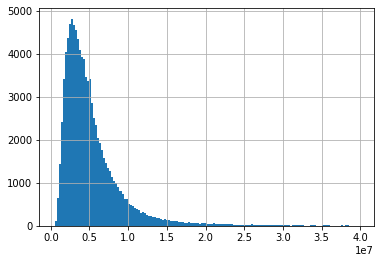

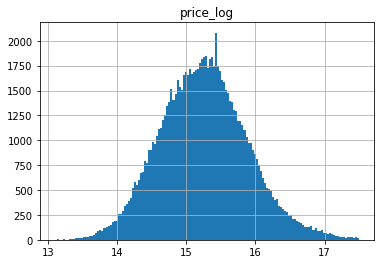

In [16]:
y.hist(bins = 150)
df_1.hist(column = 'price_log', bins = 150)

In [17]:
sc = StandardScaler()
X_scaled = sc.fit_transform(X, y)

In [18]:
X_scaled

array([[ 1.45049651, -0.90844428, -0.3398851 , ..., -0.01407518,
        -0.70010241, -1.42246663],
       [-1.14797054, -0.90844428, -0.5870403 , ..., -0.01407518,
        -0.70010241, -1.42246663],
       [-0.53959929, -0.90844428,  0.89589091, ..., -0.01407518,
        -0.70010241, -1.42246663],
       ...,
       [ 1.11022106, -0.90844428,  0.89589091, ..., -0.01407518,
         1.42836246, -0.90421342],
       [ 1.34222705,  0.80473383,  1.14304611, ..., -0.01407518,
         1.42836246, -0.90421342],
       [ 0.27499951,  0.80473383, -0.83419551, ..., -0.01407518,
         1.42836246, -0.90421342]])

In [19]:
def CV_regression(model, X, y, n_splits = 5, n_repeats = 10):
    temp_train_mae = []
    temp_test_mae  = []
    
    rkfold = RepeatedKFold(n_splits = n_splits, n_repeats = n_repeats, random_state = 42)
    temp = 1
    
    for train, test in rkfold.split(X):
        #print(temp, end = '')
        X_train, X_test, y_train, y_test = X[train], X[test], y.values[train], y.values[test]
        model.fit(X_train, y_train)
        train_ans = model.predict(X_train)
        test_ans = model.predict(X_test)
        temp_train_mae.append(mae(y_train, train_ans))
        temp_test_mae.append( mae(y_test , test_ans ))
        temp += 1
    
    #print()
    return temp_train_mae, temp_test_mae

### Lasso ###

In [21]:
alpha_grid = [0.001, 0.01, 0.1, 0.2, 0.3, 0.5, 1.0]
train_mae = []
test_mae = []

temp_train_mae = []
temp_test_mae  = []
    
for alpha in tqdm_notebook(alpha_grid):
    lasso = Lasso(alpha = alpha, random_state = 42)  
    temp_train_mae, temp_test_mae = CV_regression(lasso, X_scaled, y)
    
    train_mae.append(np.mean(temp_train_mae))
    test_mae.append(np.mean(temp_test_mae))

print("Train:\n", min(train_mae), "({})".format(alpha_grid[np.argmin(train_mae)]))
print("Test:\n", min(test_mae),   "({})".format(alpha_grid[np.argmin(test_mae)]))


Train:
 1651307.9952754378 (1.0)
Test:
 1652119.5691008612 (1.0)


### Ridge ###

In [23]:
alpha_grid = [0.001, 0.01, 0.1, 0.2, 0.3, 0.5, 1.0]
train_mae = []
test_mae = []

temp_train_mae = []
temp_test_mae  = []
    
for alpha in tqdm_notebook(alpha_grid):
    ridge = Ridge(alpha = alpha, random_state = 42)  
    temp_train_mae, temp_test_mae = CV_regression(ridge, X_scaled, y)
    
    train_mae.append(np.mean(temp_train_mae))
    test_mae.append(np.mean(temp_test_mae))

print("Train:\n", min(train_mae), "({})".format(alpha_grid[np.argmin(train_mae)]))
print("Test:\n", min(test_mae),   "({})".format(alpha_grid[np.argmin(test_mae)]))


Train:
 1651308.029694763 (0.001)
Test:
 1652119.6191892251 (0.001)


### RandomForest ###

In [20]:
supposed = int(X.shape[1]/3)
print(supposed)
features_range = np.arange(supposed - 4, supposed + 4, 2)
features_range

8


array([ 4,  6,  8, 10])

In [ ]:
parameters = {'n_estimators':     [200],
              'max_features':     features_range, 
              'min_samples_leaf': [1, 3, 5, 7],
              'max_depth':        [5, 10, 15, 20, 30, 50]}

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state = 42)

rfr = RandomForestRegressor(random_state=42, n_jobs=18, oob_score=True, criterion='mse')
gcv = GridSearchCV(rfr, parameters, n_jobs=18, cv=kfold, verbose=1, scoring = 'neg_mean_absolute_error')
gcv.fit(X, y)

In [33]:
gcv.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=50, max_features=10, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=18, oob_score=True,
                      random_state=42, verbose=0, warm_start=False)

In [34]:
gcv.best_score_

-1513511.3735590822

In [25]:
RFC = RandomForestRegressor(max_depth=50, max_features=10,
                            min_samples_leaf = 1, min_samples_split=2,
                            n_estimators=200, 
                            n_jobs=18, oob_score=True,
                            random_state=42)

train_mae, test_mae = CV_regression(RFC, X_scaled, y, 5, 1)

print("Train:\n", np.mean(train_mae))
print("Test:\n", np.mean(test_mae))

Train:
 564635.8441992132
Test:
 1527657.5687255047


### GradientBoosting ###

In [43]:
parameters = {'n_estimators':     [100],
              'max_features':     features_range, 
              'min_samples_leaf': [1, 3, 5, 7],
              'max_depth':        [5, 10, 15, 20, 30],
              'learning_rate':    [0.01, 0.05, 0.1, 0.25, 0.5]}

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state = 42)

gbr = GradientBoostingRegressor(random_state=42)
gcv = GridSearchCV(gbr, parameters, n_jobs=18, cv=kfold, verbose=1, scoring = make_scorer(mae, greater_is_better = False))
gcv.fit(X_scaled, y)

Fitting 5 folds for each of 400 candidates, totalling 2000 fits


[Parallel(n_jobs=18)]: Using backend LokyBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   28.3s
[Parallel(n_jobs=18)]: Done 164 tasks      | elapsed:  5.7min
[Parallel(n_jobs=18)]: Done 414 tasks      | elapsed: 16.0min
[Parallel(n_jobs=18)]: Done 764 tasks      | elapsed: 30.5min
[Parallel(n_jobs=18)]: Done 1214 tasks      | elapsed: 51.3min
[Parallel(n_jobs=18)]: Done 1764 tasks      | elapsed: 77.4min
[Parallel(n_jobs=18)]: Done 2000 out of 2000 | elapsed: 90.9min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2...
                                                 verbose=0, warm_start=False),
             iid='deprecated', n_jobs=18,
             param_grid={'learning_rate': 

In [44]:
gcv.best_estimator_

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.5, loss='ls', max_depth=10,
                          max_features=10, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=7, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [45]:
gcv.best_score_

-928849.1694369616

In [20]:
GBR = GradientBoostingRegressor(learning_rate=0.5, max_depth=10,
                                max_features = 10,
                                min_samples_leaf = 7, n_estimators = 100,
                                random_state=42)

train_mae, test_mae = CV_regression(GBR, X_scaled, y, 5, 1)

print("Train:\n", np.mean(train_mae))
print("Test:\n", np.mean(test_mae))

Train:
 518007.3426559371
Test:
 929385.1337988091


In [21]:
GBR = GradientBoostingRegressor(learning_rate=0.5, max_depth=10,
                                max_features = 10,
                                min_samples_leaf = 7, n_estimators = 200,
                                random_state=42)

train_mae, test_mae = CV_regression(GBR, X_scaled, y, 5, 1)

print("Train:\n", np.mean(train_mae))
print("Test:\n", np.mean(test_mae))

Train:
 319135.0171129828
Test:
 854489.3259373903


In [22]:
GBR = GradientBoostingRegressor(learning_rate=0.5, max_depth=10,
                                max_features = 10,
                                min_samples_leaf = 7, n_estimators = 300,
                                random_state=42)

train_mae, test_mae = CV_regression(GBR, X_scaled, y, 5, 1)

print("Train:\n", np.mean(train_mae))
print("Test:\n", np.mean(test_mae))

Train:
 221725.05211228938
Test:
 839147.1085801944


In [23]:
GBR = GradientBoostingRegressor(learning_rate=0.5, max_depth=10,
                                max_features = 10,
                                min_samples_leaf = 7, n_estimators = 400,
                                random_state=42)

train_mae, test_mae = CV_regression(GBR, X_scaled, y, 5, 1)

print("Train:\n", np.mean(train_mae))
print("Test:\n", np.mean(test_mae))

Train:
 160495.57385253807
Test:
 834406.761890797


## Модель ##

In [13]:
def get_class1(mass):
    class1_id = []
    for i in range(len(mass)):
        if mass[i] == 1:
            class1_id.append(i)
    return class1_id

In [14]:
class my_model:
    
    def __init__(self, classificator, regressor):
        self.classificator = classificator
        self.regressor = regressor

    def fit(self,X_train, y_class, y_regr):
        self.classificator.fit(X_train, y_class)
        
        class1_id = get_class1(y_class)
        X_train_regr = X_train[class1_id]
        self.regressor.fit(X_train_regr, y_regr[class1_id])
    
    def predict(self,X_test):
        y_pred_class = self.classificator.predict(X_test)
        
        class1_id = get_class1(y_pred_class)
        X_test_regr = X_test[class1_id]
        y_pred_regr = self.regressor.predict(X_test_regr)
        
        y_res = np.zeros(len(y_pred_class))
        temp_regr = 0
        for temp in range(len(y_pred_class)):
            if y_pred_class[temp] == 1:
                y_res[temp] = y_pred_regr[temp_regr]
                temp_regr += 1
            else:
                y_res[temp] = 1000000
                
        return y_res

In [15]:
classificator = LogisticRegression(solver='liblinear', random_state=42)
regressor     = GradientBoostingRegressor(learning_rate=0.5, max_depth=10,
                                          max_features = 10,
                                          min_samples_leaf = 7, n_estimators = 300,
                                          random_state=42)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state = 42)

In [ ]:
train_names = ['street_id', 'build_tech', 'floor', 'area', 'rooms', 'balcon',
               'metro_dist', 'g_lift', 'n_photos', 'kw1', 'kw2', 'kw3', 'kw4', 'kw5',
               'kw6', 'kw7', 'kw8', 'kw9', 'kw10', 'kw11', 'kw12', 'kw13', 'year', 'month','time']

In [81]:
X       = df[train_names]
y_class = df['class']
y_price = df['price']

sc_x = StandardScaler()
X_scaled = sc_x.fit_transform(X)

In [89]:
model = my_model(classificator, regressor)
train_mae = []
test_mae  = []

for train, test in kfold.split(X_scaled, y_class):
    X_train, X_test = X_scaled[train], X_scaled[test]
    y_class_train, y_class_test = y_class.values[train], y_class.values[test]
    y_regr_train,  y_regr_test  = y_price.values[train], y_price.values[test]
    model.fit(X_train, y_class_train, y_regr_train)
    
    y_pred_train = model.predict(X_train)
    train_mae.append(mae(y_pred_train, y_regr_train))
    y_pred_test = model.predict(X_test)
    test_mae.append(mae(y_pred_test, y_regr_test))
    
print("Train:\n", np.mean(train_mae))
print("Test:\n", np.mean(test_mae))

Train:
 383040.96184943616
Test:
 966763.6983755376


А если без классификатора:

In [92]:
class my_model2:
    
    def __init__(self, regressor):
        self.regressor = regressor

    def fit(self,X_train, y_class, y_regr):
        class1_id = get_class1(y_class)
        X_train_regr = X_train[class1_id]
        self.regressor.fit(X_train_regr, y_regr[class1_id])
    
    def predict(self,X_test):
        y_pred_regr = self.regressor.predict(X_test)      
        return y_pred_regr

In [93]:
model = my_model2(regressor)
train_mae = []
test_mae  = []

for train, test in kfold.split(X_scaled, y_class):
    X_train, X_test = X_scaled[train], X_scaled[test]
    y_class_train, y_class_test = y_class.values[train], y_class.values[test]
    y_regr_train,  y_regr_test  = y_price.values[train], y_price.values[test]
    model.fit(X_train, y_class_train, y_regr_train)
    
    y_pred_train = model.predict(X_train)
    train_mae.append(mae(y_pred_train, y_regr_train))
    y_pred_test = model.predict(X_test)
    test_mae.append(mae(y_pred_test, y_regr_test))
    
print("Train:\n", np.mean(train_mae))
print("Test:\n", np.mean(test_mae))

Train:
 383040.96184943616
Test:
 966763.6983755376


# Итоги #

## Тесты ##

In [64]:
train_names = ['street_id', 'build_tech', 'floor', 'area', 'rooms', 'balcon',
               'metro_dist', 'g_lift', 'n_photos', 'kw1', 'kw2', 'kw3', 'kw4', 'kw5',
               'kw6', 'kw7', 'kw8', 'kw9', 'kw10', 'kw11', 'kw12', 'kw13', 'time']

df_1    = df[df['id'] < 50000]
X_1 = df_1[train_names]
y_1 = df_1['price']
y_1_class = df_1['class']

df_2   = df[df['id'] > 50000]
X_2 = df_2[train_names]
y_2 = df_2['price']
y_2_class = df_2['class']

In [ ]:
parametres = {'learning_rate': [0.1, 0.2, 0.3],
              'max_features' : [10,11,12,12],
              'min_samples_leaf': [5,7,9,11]}

test_mae = []

for temp in tqdm_notebook(range(48)):
    lr_id  = int(temp / 16)
    mf_id  = int(temp / 4) % 4
    msl_id = temp % 4
    learning_rate    = parametres['learning_rate'   ][lr_id ]
    max_features     = parametres['max_features'    ][mf_id ]
    min_samples_leaf = parametres['min_samples_leaf'][msl_id ]
    regressor = GradientBoostingRegressor(learning_rate=learning_rate,
                                          max_features = max_features,
                                          min_samples_leaf = min_samples_leaf,
                                          n_estimators = 300, max_depth=10, random_state=42)
    classificator = LogisticRegression(solver='liblinear', random_state=42)
    model = my_model(classificator, regressor)
    
    temp_res = []
    
    X_train, X_test = X_1, X_2
    y_train, y_test = y_1, y_2
    y_class         = y_1
    sc = StandardScaler()
    X_train_scaled = sc.fit_transform(X_train, y_train)
    X_test_scaled = sc.fit_transform(X_train, y_train)
    
    model.fit(X_train_scaled, y_class.values, y_train.values)
    y_pred = model.predict(X_test_scaled)
    temp_res.append(mae (y_pred, y_test.values))
                    
    X_train, X_test = X_2, X_1
    y_train, y_test = y_2, y_1
    y_class         = y_2
    sc = StandardScaler()
    X_train_scaled = sc.fit_transform(X_train, y_train)
    X_test_scaled = sc.fit_transform(X_train, y_train)
    
    model.fit(X_train_scaled, y_class.values, y_train.values)
    y_pred = model.predict(X_test_scaled)
    temp_res.append(mae (y_pred, y_test.values))
                    
    test_mae.append(np.mean(temp_res))

In [192]:
X_train = X_2
y_train = y_2
y_class = y_2_class
X_test = X_1
y_test = y_1

In [193]:
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train, y_train)
X_test_scaled = sc.transform(X_test)

In [194]:
regressor = GradientBoostingRegressor(learning_rate=0.2, max_depth=10,
                                        max_features = 20,
                                        min_samples_leaf = 7, n_estimators = 300,
                                        random_state=42)
classificator = LogisticRegression(solver='liblinear', random_state=42)
model = my_model(classificator, regressor)

In [195]:
model.fit(X_train_scaled, y_class.values, y_train.values)
y_pred = model.predict(X_test_scaled)

In [196]:
score = mae(y_pred, y_test.values)
score

824606.397659558

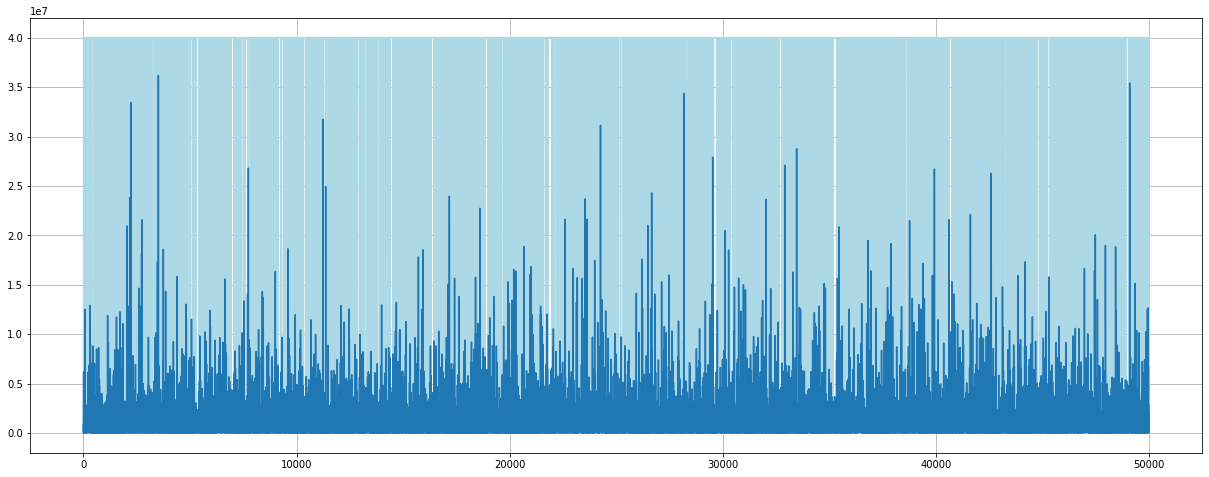

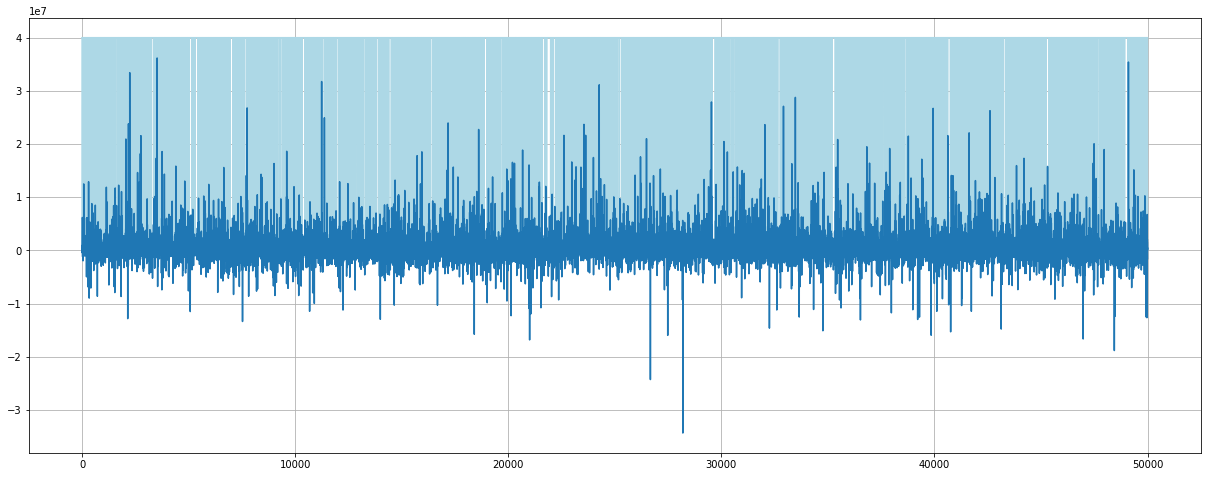

In [200]:
import matplotlib.pyplot as plt

plt.figure(figsize=(21, 8)) 
plt.plot(df_1["id"], df_1['class'].values*4e7, color = 'lightblue')
plt.plot(df_1["id"], abs(y_pred - y_test.values)) 
plt.grid()
plt.show()
plt.figure(figsize=(21, 8)) 
plt.plot(df_1["id"], df_1['class'].values*4e7, color = 'lightblue')
plt.plot(df_1["id"], y_pred - y_test.values)
plt.grid()
plt.show()

In [101]:
output_df = pd.DataFrame()
output_df['id'] = df_2['id']
output_df['price_pred'] = y_pred
output_df['price'] = y_test.values
output_df['class'] = df_2['class']
output_df

,id,price_pred,price,class
50001,50001,3.702513e+06,3556000,1
50002,50002,1.161160e+06,4716000,1
50003,50003,4.308284e+06,4597000,1
50004,50004,5.864869e+06,5420000,1
50005,50005,1.052553e+07,13132000,1
...,...,...,...,...
99995,99995,3.425918e+06,3898000,1
99996,99996,8.106872e+06,8698000,1
99997,99997,4.949197e+06,6498000,1
99998,99998,8.233837e+06,9436000,1


## Train data ##

In [203]:
train_names = ['street_id', 'build_tech', 'floor', 'area', 'rooms', 'balcon',
               'metro_dist', 'g_lift', 'n_photos', 'kw1', 'kw2', 'kw3', 'kw4', 'kw5',
               'kw6', 'kw7', 'kw8', 'kw9', 'kw10', 'kw11', 'kw12', 'kw13', 'time']

#df_1    = df[df['class'] == 1]
X_train = df[train_names]
y_train = df['price']
y_class = df['class']

In [204]:
X_train

,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,n_photos,kw1,...,kw5,kw6,kw7,kw8,kw9,kw10,kw11,kw12,kw13,time
0,616,0.0,4,43,2,0,30.0,1.0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,112,0.0,3,33,1,0,15.0,1.0,2,0,...,0,0,0,0,0,0,0,0,0,1
2,230,1.0,9,34,1,0,25.0,1.0,4,0,...,0,0,0,0,0,0,0,0,0,1
3,302,1.0,4,60,3,0,15.0,0.0,2,1,...,0,0,0,0,0,0,0,0,0,1
4,578,0.0,3,49,2,0,30.0,0.0,2,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,612,0.0,3,36,1,0,30.0,1.0,3,0,...,0,0,0,0,0,0,0,0,0,15
99996,573,0.0,4,51,2,0,30.0,1.0,3,0,...,0,0,0,0,0,0,0,0,0,15
99997,550,0.0,9,48,2,0,30.0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,15
99998,595,1.0,10,51,2,1,15.0,1.0,1,0,...,0,0,0,0,0,0,0,0,0,15


In [205]:
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train, y_train)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E7ABB882C8>]],
      dtype=object)

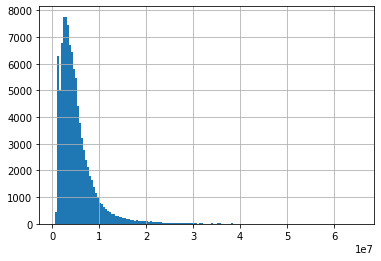

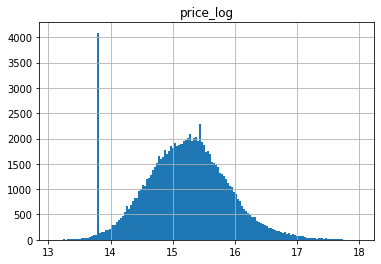

In [206]:
y_train.hist(bins = 150)
df.hist(column = 'price_log', bins = 150)

## Test data ##

In [20]:
df_test = pd.read_csv("./data/task5/Test.csv")
df_test

,id,date,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,...,kw4,kw5,kw6,kw7,kw8,kw9,kw10,kw11,kw12,kw13
0,100000,2012-3,422,0.0,1,59,3,0,25.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,100001,2012-3,380,0.0,10,58,2,0,NaN,NaN,...,0,0,0,1,0,0,0,0,0,0
2,100002,2012-3,362,1.0,3,54,2,0,10.0,NaN,...,0,0,0,0,0,0,0,0,0,0
3,100003,2012-3,34,0.0,4,35,1,0,25.0,1.0,...,0,0,0,0,0,0,0,0,0,0
4,100004,2012-3,562,0.0,4,56,3,0,30.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,199995,2013-9,89,0.0,2,43,2,0,30.0,0.0,...,0,0,0,0,0,0,0,0,0,0
99996,199996,2013-9,664,1.0,7,62,3,1,30.0,NaN,...,0,0,0,0,0,0,0,0,0,0
99997,199997,2013-9,358,NaN,2,35,1,1,30.0,0.0,...,0,0,0,0,0,0,0,0,0,0
99998,199998,2013-9,224,1.0,3,52,2,1,30.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
for street_id in tqdm_notebook(set(df['street_id'])):
    # missed_value возьмем как для обучающей выборки
    missed_value = np.mean(df[df['street_id'] == street_id]["metro_dist"])
    for kid_ in df_test[df_test['street_id'] == street_id]['id']:
        id_ = kid_ - 100000
        if np.isnan(df_test['metro_dist'][id_]):
            df_test['metro_dist'][id_] = missed_value

In [22]:
value_counts = df["build_tech"].value_counts()
total_count = value_counts[0] + value_counts[1] + value_counts[2]
p_0  = value_counts[0] / total_count
p_1  = value_counts[1] / total_count
p_2  = value_counts[2] / total_count
perm = [p_0, p_1, p_2]

for kid_ in tqdm_notebook(df_test['id']):
    id_ = kid_ - 100000
    if np.isnan(df_test['build_tech'][id_]):
        df_test['build_tech'][id_] = np.random.choice([0.0, 1.0, 2.0], p = perm)

In [23]:
for kid_ in tqdm_notebook(df_test['id']):
    id_ = kid_ - 100000
    if np.isnan(df_test['g_lift'][id_]):
        df_test['g_lift'][id_] = np.random.choice([0.0, 1.0])

In [25]:
year  = []
month = []
time  = []
for id_ in tqdm_notebook(range(df_test.shape[0])):
    data = df_test['date'][id_].split('-')
    curr_year  = int(data[0])
    curr_month = int(data[1])
    curr_time = curr_month
    if curr_year > 2012:
        curr_time += 12
    year.append(curr_year)
    month.append(curr_month)
    time.append(curr_time)
df_test['year']  = year
df_test['month'] = month
df_test['time']  = time
#df_test.drop(['date'], axis='columns', inplace=True)

In [207]:
df_test

,id,date,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,...,kw7,kw8,kw9,kw10,kw11,kw12,kw13,year,month,time
0,100000,2012-3,422,0.0,1,59,3,0,25.000000,0.0,...,0,0,0,0,0,0,0,2012,3,3
1,100001,2012-3,380,0.0,10,58,2,0,21.753247,1.0,...,1,0,0,0,0,0,0,2012,3,3
2,100002,2012-3,362,1.0,3,54,2,0,10.000000,1.0,...,0,0,0,0,0,0,0,2012,3,3
3,100003,2012-3,34,0.0,4,35,1,0,25.000000,1.0,...,0,0,0,0,0,0,0,2012,3,3
4,100004,2012-3,562,0.0,4,56,3,0,30.000000,0.0,...,0,0,0,0,0,0,0,2012,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,199995,2013-9,89,0.0,2,43,2,0,30.000000,0.0,...,0,0,0,0,0,0,0,2013,9,21
99996,199996,2013-9,664,1.0,7,62,3,1,30.000000,1.0,...,0,0,0,0,0,0,0,2013,9,21
99997,199997,2013-9,358,1.0,2,35,1,1,30.000000,0.0,...,0,0,0,0,0,0,0,2013,9,21
99998,199998,2013-9,224,1.0,3,52,2,1,30.000000,0.0,...,0,0,0,0,0,0,0,2013,9,21


In [201]:
X_test = df_test[train_names]
X_test

,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,n_photos,kw1,...,kw5,kw6,kw7,kw8,kw9,kw10,kw11,kw12,kw13,time
0,422,0.0,1,59,3,0,25.000000,0.0,1,0,...,0,0,0,0,0,0,0,0,0,3
1,380,0.0,10,58,2,0,21.753247,1.0,4,0,...,0,0,1,0,0,0,0,0,0,3
2,362,1.0,3,54,2,0,10.000000,1.0,2,0,...,0,0,0,0,0,0,0,0,0,3
3,34,0.0,4,35,1,0,25.000000,1.0,0,0,...,0,0,0,0,0,0,0,0,0,3
4,562,0.0,4,56,3,0,30.000000,0.0,2,0,...,0,0,0,0,0,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,89,0.0,2,43,2,0,30.000000,0.0,0,0,...,0,0,0,0,0,0,0,0,0,21
99996,664,1.0,7,62,3,1,30.000000,1.0,7,0,...,0,0,0,0,0,0,0,0,0,21
99997,358,1.0,2,35,1,1,30.000000,0.0,1,1,...,0,0,0,0,0,0,0,0,0,21
99998,224,1.0,3,52,2,1,30.000000,0.0,1,0,...,0,0,0,0,0,0,0,0,0,21


In [202]:
X_test_scaled = sc.transform(X_test)

## Модель ##

In [208]:
regressor = GradientBoostingRegressor(learning_rate=0.2, max_depth=10,
                                        max_features = 12,
                                        min_samples_leaf = 7, n_estimators = 300,
                                        random_state=42)
classificator = LogisticRegression(solver='liblinear', random_state=42)
model = my_model(classificator, regressor)

In [209]:
model.fit(X_train_scaled, y_class.values, y_train.values)
y_pred = model.predict(X_test_scaled)

In [210]:
output_df = pd.DataFrame()
output_df['id'] = df_test['id']
output_df['price'] = y_pred
output_df

,id,price
0,100000,3.833302e+06
1,100001,6.743723e+06
2,100002,3.717054e+06
3,100003,1.958489e+06
4,100004,2.690777e+06
...,...,...
99995,199995,1.280851e+06
99996,199996,1.084738e+07
99997,199997,6.396272e+06
99998,199998,3.875032e+06


In [211]:
output_df.to_csv("Submission3.csv", index=False)

# Результаты #

In [213]:
df1sub = pd.read_csv("Submission1.csv")
df2sub = pd.read_csv("Submission2.csv")

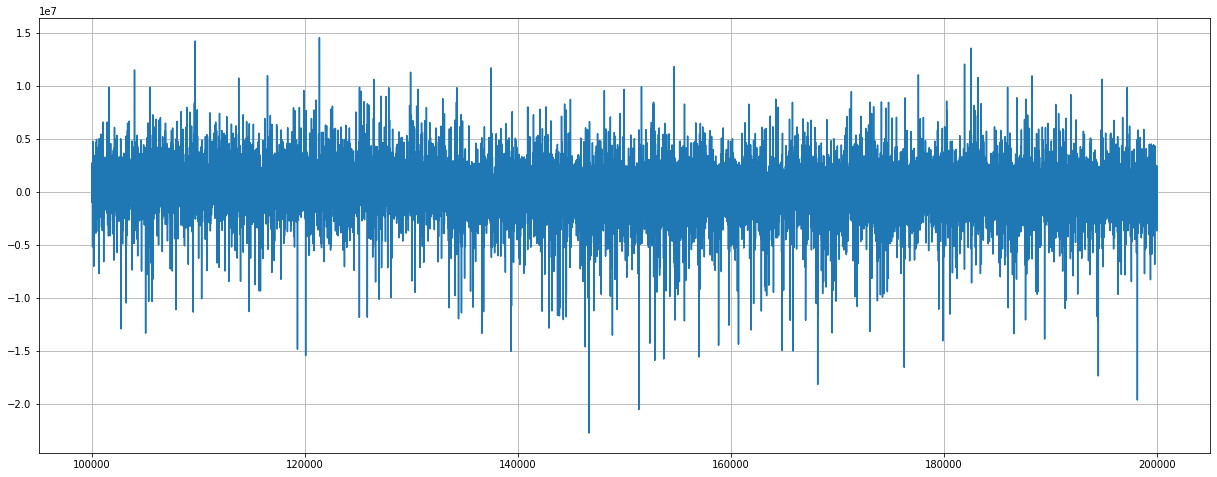

In [56]:
import matplotlib.pyplot as plt

plt.figure(figsize=(21, 8))
#plt.plot(df1sub["id"], np.sort(), label = "sub_1")
plt.plot(df2sub["id"], df1sub["price"] - df2sub["price"], label = "sub_2")  
plt.grid()
plt.show()

In [55]:
np.mean(df1sub["price"] - df2sub["price"])

-102593.06517285628

In [60]:
df1sub['price_log'] = np.log(df1sub['price'])
df2sub['price_log'] = np.log(df2sub['price'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E7AF9C1488>]],
      dtype=object)

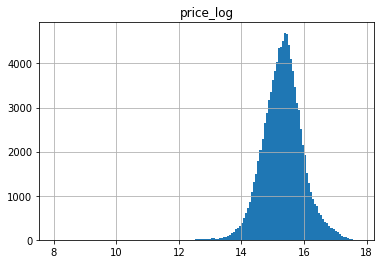

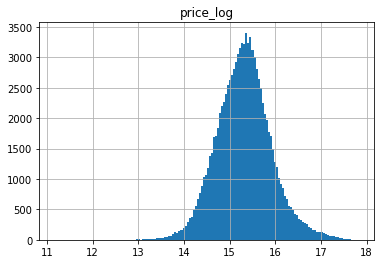

In [103]:
df1sub.hist(column = 'price_log', bins = 150)
df2sub.hist(column = 'price_log', bins = 150)